In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download the Dataset

In [ ]:
# install kaggle
!pip install -q kaggle

In [ ]:
# create kaggle folder
!mkdir ~/.kaggle

# copy the kaggle.json to the folder created
!cp /content/drive/MyDrive/Colab_Notebooks/Kaggle_API_Token/kaggle.json ~/.kaggle/

# permission for the jason to act
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Loading the dataset using Kaggle API Command
!kaggle datasets download -d chitholian/annotated-potholes-dataset

 72% 33.0M/45.9M [00:00<00:00, 182MB/s] 
100% 45.9M/45.9M [00:00<00:00, 155MB/s]


In [ ]:
# Unzipping the dataset
!unzip /content/annotated-potholes-dataset.zip

# Prepare Dataset

In [ ]:
paths = {'DATASET_PATH': '/content/dataset',
         'IMAGES_PATH': '/content/dataset/images',
         'LABELS_PATH': '/content/dataset/labels',
         'IMAGES_PATH_TRAIN': '/content/dataset/images/train',
         'IMAGES_PATH_VAL': '/content/dataset/images/val',
         'LABELS_PATH_TRAIN': '/content/dataset/labels/train',
         'LABELS_PATH_VAL': '/content/dataset/labels/val',
         'TEMP_IMAGES_PATH': '/content/temp_images',
         'TEMP_LABELS_PATH': '/content/temp_labels',
         'YOLO_LABELS_PATH': '/content/yolo_labels'}

In [ ]:
# create the directories
import os

for path in paths.values():
    if not os.path.exists(path):
        os.mkdir(path)

#### Seperate the images and annotations in different folders

In [ ]:
import shutil

DATA_SOURCE_PATH = '/content/annotated-images'

file_names = [fil[:-4] for fil in os.listdir(DATA_SOURCE_PATH) if fil[-4:] == '.jpg']

for file_name in file_names:
    image_source = os.path.join(DATA_SOURCE_PATH, file_name+'.jpg')
    annotation_source = os.path.join(DATA_SOURCE_PATH, file_name+'.xml')
    image_destination = os.path.join(paths['TEMP_IMAGES_PATH'], file_name+'.jpg')
    annotation_destination = os.path.join(paths['TEMP_LABELS_PATH'], file_name+'.xml')
    shutil.copyfile(image_source, image_destination)
    shutil.copyfile(annotation_source, annotation_destination)

#### Convert the annotations from `.xml` format to yolo `.txt` format

In [ ]:
input_dir = paths['TEMP_LABELS_PATH']
output_dir = paths['YOLO_LABELS_PATH']
image_dir = paths['TEMP_IMAGES_PATH']
image_file_extension = '.jpg'

import xml.etree.ElementTree as ET
import glob
import os
import json


def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]


def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]


classes = []

# create the labels folder (output directory)
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
    
# identify all the xml files in the annotations folder (input directory)
files = glob.glob(os.path.join(input_dir, '*.xml'))
# loop through each 
for fil in files:
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]
    # check if the label contains the corresponding image file
    if not os.path.exists(os.path.join(image_dir, f"{filename}" + image_file_extension)):
        print(f"{filename} image does not exist!")
        continue

    result = []

    # parse the content of the xml file
    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall('object'):
        label = obj.find("name").text
        # check for new classes and append to list
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        # convert data to string
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")

    if result:
        # generate a YOLO format text file for each xml file
        with open(os.path.join(output_dir, f"{filename}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))

# generate the classes file as reference
with open('classes.txt', 'w', encoding='utf8') as f:
    f.write(json.dumps(classes))

#### Define classes and their colors

In [ ]:
classes = {0: 'pothole'}
colors = {'pothole': (0,50,255)}

#### Custom visualization functions

In [ ]:
import cv2

def draw_focused_rectangle(image, bbox, color, corner_length = 30, corner_thickness = 4, edge_thickness = 1):
    img = image.copy()

    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]

    if (x1+corner_length > x2) or (y1+corner_length > y2):
        cv2.rectangle(img, (x1, y1), (x2, y2), color = color, thickness = edge_thickness)
    else:
        cv2.rectangle(img, (x1, y1), (x2, y2), color = color, thickness = edge_thickness)
        # top left corner
        cv2.line(img, (x1, y1), (x1+corner_length, y1), color = color, thickness = corner_thickness)
        cv2.line(img, (x1, y1), (x1, y1+corner_length), color = color, thickness = corner_thickness)
        # top right corner
        cv2.line(img, (x2, y1), (x2-corner_length, y1), color = color, thickness = corner_thickness)
        cv2.line(img, (x2, y1), (x2, y1+corner_length), color = color, thickness = corner_thickness)
        # bottom left corner
        cv2.line(img, (x1, y2), (x1+corner_length, y2), color = color, thickness = corner_thickness)
        cv2.line(img, (x1, y2), (x1, y2-corner_length), color = color, thickness = corner_thickness)
        # bottom right corner
        cv2.line(img, (x2, y2), (x2-corner_length, y2), color = color, thickness = corner_thickness)
        cv2.line(img, (x2, y2), (x2, y2-corner_length), color = color, thickness = corner_thickness)

    return img

def draw_label(image, label, x, y, box_color, font_color, font_face = cv2.FONT_HERSHEY_SIMPLEX, font_scale = 0.5):
    img = image.copy()

    text_size = cv2.getTextSize(label, fontFace=font_face, fontScale=font_scale, thickness=1)
    dim, baseline = text_size[0], text_size[1]
    
    # cv2.rectangle(img, (x,y), (x + dim[0], y + dim[1] + baseline), box_color, cv2.FILLED);
    # cv2.putText(img, label, (x, y + dim[1] + 2), fontFace=font_face, fontScale=font_scale, color=font_color, thickness=1)

    cv2.rectangle(img, (x, y - dim[1] - baseline), (x + dim[0], y), box_color, cv2.FILLED);
    cv2.putText(img, label, (x, y - dim[1] + 7), fontFace=font_face, fontScale=font_scale, color=font_color, thickness=1)

    return img

#### A sanity check for the sake of annotation convertion

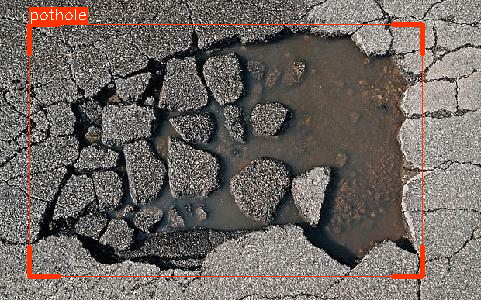

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import random

file_name = random.sample(file_names, 1)[0]
SAMPLE_IMAGE_PATH = paths['TEMP_IMAGES_PATH'] + '/' + file_name + '.jpg'
SAMPLE_LABEL_PATH = paths['YOLO_LABELS_PATH'] + '/' + file_name + '.txt'
sample_image = cv2.imread(SAMPLE_IMAGE_PATH)
height = sample_image.shape[0]
width = sample_image.shape[1]


with open(SAMPLE_LABEL_PATH, 'r') as f:
    contents = f.read()
    contents = contents.split('\n')

for detection in contents:
    detection = detection.split(' ')
    cls_id = int(detection[0])
    cls = classes[0]
    color = colors[cls]
    bbox_yolo = [float(num) for num in detection[1:]]
    xmin, ymin, xmax, ymax = yolo_to_xml_bbox(bbox_yolo, width, height)
    # cv2.rectangle(sample_image, (xmin, ymin), (xmax, ymax), color, thickness = 2)
    sample_image = draw_focused_rectangle(sample_image, (xmin, ymin, xmax, ymax), color)
    sample_image = draw_label(sample_image, cls, xmin, ymin, color, (255,255,255))

cv2_imshow(sample_image)

#### Split the train and test images & annotations

In [ ]:
import json

split_json_file_path = '/content/splits.json'

with open(split_json_file_path, 'r') as j:
     split = json.loads(j.read())

file_names_train = [fil[:-4] for fil in split['train'] if fil[-4:] == '.xml']
file_names_test = [fil[:-4] for fil in split['test'] if fil[-4:] == '.xml']

DATA_SOURCE_PATH = '/content/annotated-images'

for file_name in file_names_train:
    image_source = os.path.join(DATA_SOURCE_PATH, file_name+'.jpg')
    annotation_source = os.path.join(paths['YOLO_LABELS_PATH'], file_name+'.txt')
    image_destination = os.path.join(paths['IMAGES_PATH_TRAIN'], file_name+'.jpg')
    annotation_destination = os.path.join(paths['LABELS_PATH_TRAIN'], file_name+'.txt')
    shutil.copyfile(image_source, image_destination)
    shutil.copyfile(annotation_source, annotation_destination)

for file_name in file_names_test:
    image_source = os.path.join(DATA_SOURCE_PATH, file_name+'.jpg')
    annotation_source = os.path.join(paths['YOLO_LABELS_PATH'], file_name+'.txt')
    image_destination = os.path.join(paths['IMAGES_PATH_VAL'], file_name+'.jpg')
    annotation_destination = os.path.join(paths['LABELS_PATH_VAL'], file_name+'.txt')
    shutil.copyfile(image_source, image_destination)
    shutil.copyfile(annotation_source, annotation_destination)

In [ ]:
print('No. of images: ', len(file_names))
print('No. of train images: ', len(os.listdir(paths['IMAGES_PATH_TRAIN'])))
print('No. of train labels: ', len(os.listdir(paths['LABELS_PATH_TRAIN'])))
print('No. of validation images: ', len(os.listdir(paths['IMAGES_PATH_VAL'])))
print('No. of validation labels: ', len(os.listdir(paths['LABELS_PATH_VAL'])))

No. of images:  665
No. of train images:  532
No. of train labels:  532
No. of validation images:  133
No. of validation labels:  133


# Setup for YoloV5

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.7/78.2 GB disk)


In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2

# Model Training

In [ ]:
# Copy the gun_detection.yaml from drive to yolov5 directory
import shutil
dataset_yaml_source = '/content/drive/MyDrive/Colab_Notebooks/Object_Detection/YoloV5/YoloV5_Pothole/pothole_detection.yaml'
dataset_yaml_destination = '/content/yolov5/pothole_detection.yaml'
shutil.copyfile(dataset_yaml_source, dataset_yaml_destination)

'/content/yolov5/pothole_detection.yaml'

#### Run `train.py` for model training

In [ ]:
!python train.py --img 416 --batch 16 --epochs 100 --data pothole_detection.yaml --weights yolov5x.pt

train: weights=yolov5x.pt, cfg=, data=pothole_detection.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0

#### Save the trained model weights to drive

In [ ]:
import shutil
trained_model_weights_path = '/content/yolov5/runs/train/exp/weights/best.pt'
# save to drive
drive_destination_weights_path = '/content/drive/MyDrive/Colab_Notebooks/Object_Detection/YoloV5/YoloV5_Pothole//best.pt'

shutil.copyfile(trained_model_weights_path, drive_destination_weights_path)

'/content/drive/MyDrive/Colab_Notebooks/Object_Detection/YoloV5/YoloV5_Pothole//best.pt'

#### Convert `best.pt` file to `.onnx` format in order to inferencing with OpenCV

In [ ]:
!python export.py --weights /content/drive/MyDrive/Colab_Notebooks/Object_Detection/YoloV5/YoloV5_Pothole/best.pt --include onnx --simplify

export: data=data/coco128.yaml, weights=['/content/drive/MyDrive/Colab_Notebooks/Object_Detection/YoloV5/YoloV5_Pothole/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, train=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=True, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CPU

Fusing layers... 
Model summary: 444 layers, 86173414 parameters, 0 gradients

PyTorch: starting from /content/drive/MyDrive/Colab_Notebooks/Object_Detection/YoloV5/YoloV5_Pothole/best.pt with output shape (1, 25200, 6) (165.0 MB)
requirements: onnx not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per ['onnx']
requirements: ⚠️ Restart runtime or re

# Load the model

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'custom',
                       path='/content/drive/MyDrive/Colab_Notebooks/Object_Detection/YoloV5/YoloV5_Pothole//best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 444 layers, 86173414 parameters, 0 gradients, 203.8 GFLOPs
Adding AutoShape... 


# Do Detection

#### Custom `detect_image` function

In [ ]:
def detect_image(image_bgr, yolov5_model, detection_threshold, classes, colors):
    img = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    results = yolov5_model(img)
    detections = results.crop(save = False)

    if len(detections) == 0:
        return image_bgr

    for i in range(len(detections)):
        if detections[i]['conf'].cpu().numpy() >= detection_threshold:
            xmin = int(detections[i]['box'][0].cpu().numpy())
            ymin = int(detections[i]['box'][1].cpu().numpy())
            xmax = int(detections[i]['box'][2].cpu().numpy())
            ymax = int(detections[i]['box'][3].cpu().numpy())
            cls_id = int(detections[i]['cls'].cpu().numpy())
            conf = int(detections[i]['conf'].cpu().numpy()*100)
            cls = classes[cls_id]
            color = colors[cls][::-1]
            label = f'{cls}: {conf}%'
            
            # cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color = color, thickness = 2)
            img = draw_focused_rectangle(img, (xmin, ymin, xmax, ymax), color)
            img = draw_label(img, label, xmin, ymin, color, (255,255,255), cv2.FONT_HERSHEY_SIMPLEX, 0.5)

    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    return img

#### Detection on Image

In [ ]:
import random

IMAGES_PATHS = [paths['TEMP_IMAGES_PATH'] + '/' + fil for fil in os.listdir(paths['TEMP_IMAGES_PATH'])]
SAMPLE_IMAGE_PATH = random.sample(IMAGES_PATHS, 1)[0]

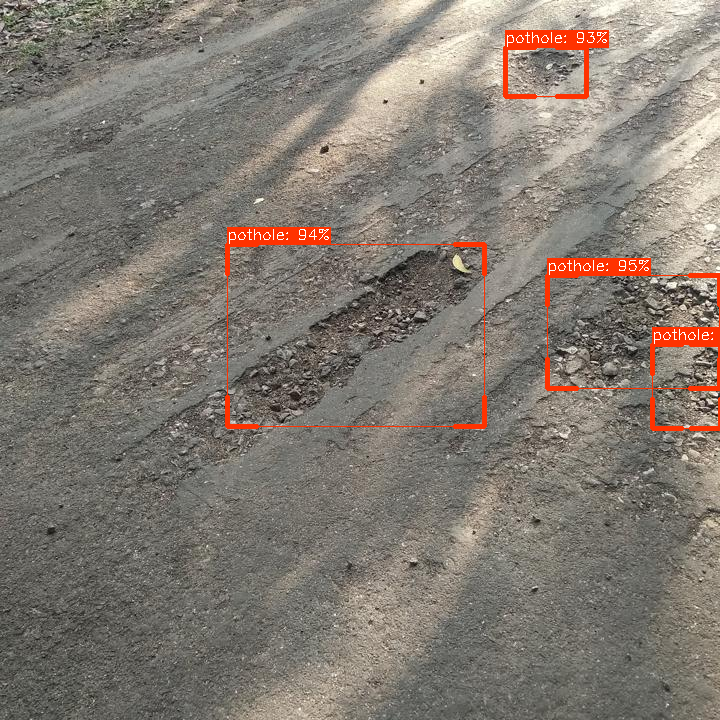

In [ ]:
from google.colab.patches import cv2_imshow

image = cv2.imread(SAMPLE_IMAGE_PATH)
detected_image = detect_image(image, model, 0.4, classes, colors)

cv2_imshow(detected_image)